In [1]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_csv('hw3.csv')
#df

In [3]:
df.drop_duplicates(inplace=True)

In [4]:
df.sort_values(by=["token","ts"],inplace=True)
df.ts=pd.to_datetime(df.ts)

In [5]:
df['token'].value_counts()

COMP                                  286
BTC                                   283
SOL                                   281
AAVE                                  280
CRV                                   279
USDT                                  278
ETH                                   270
UNI                                   270
<span name="tokenName">ETH</span>      25
<span name="tokenName">UNI</span>      25
<span name="tokenName">USDT</span>     17
<span name="tokenName">CRV</span>      16
<span name="tokenName">AAVE</span>     15
<span name="tokenName">SOL</span>      14
<span name="tokenName">BTC</span>      12
<span name="tokenName">COMP</span>      9
Name: token, dtype: int64

In [6]:
df.loc[df['token'].str.contains('span'), 'token'] = df.loc[
    df['token'].str.contains('span'), 'token'].str.extract('<span name="tokenName">(.*?)<\/span>').values

In [7]:
df['token'].value_counts()

AAVE    295
BTC     295
COMP    295
CRV     295
ETH     295
SOL     295
UNI     295
USDT    295
Name: token, dtype: int64

In [8]:
df[["open","high","low","close"]].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2360 entries, 2202 to 859
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   open    2360 non-null   float64
 1   high    1910 non-null   float64
 2   low     2104 non-null   float64
 3   close   2244 non-null   float64
dtypes: float64(4)
memory usage: 92.2 KB


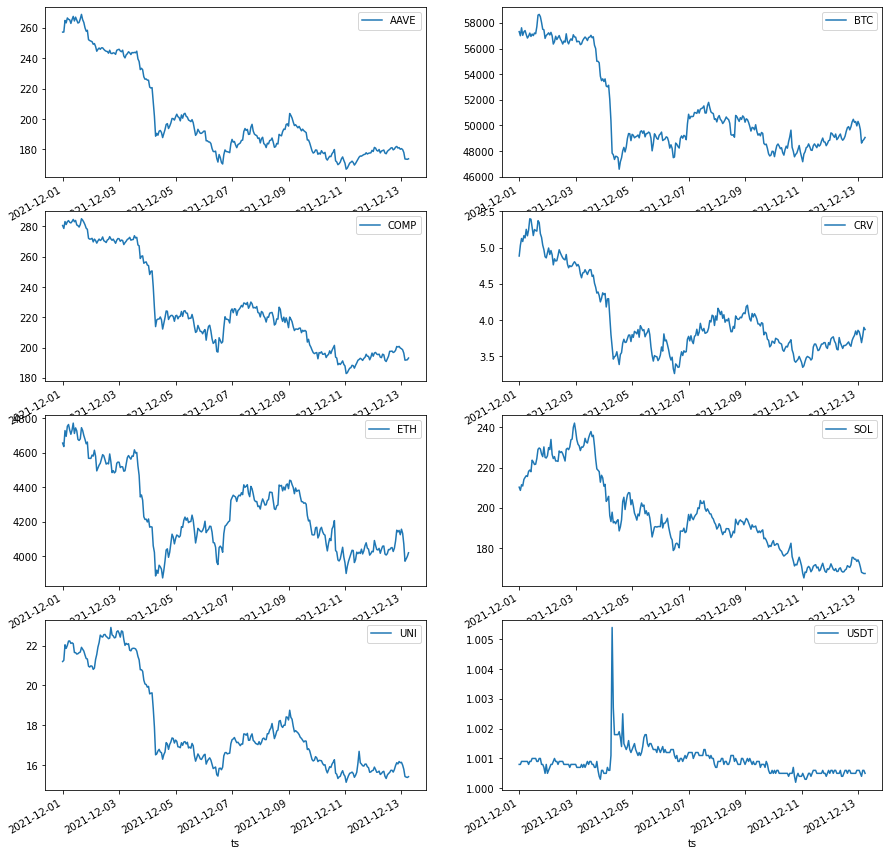

In [9]:
tokens_df = df.token.unique()

fig, axes = plt.subplots(nrows=math.ceil(tokens_df.size / 2), ncols=2, figsize=(15, 4 * math.ceil(tokens_df.size / 2)))

idx = 0
for label, df_token in df[['token', 'open',"ts"]].groupby('token'):
    df_token.set_index("ts")['open'].plot(ax=axes[idx // 2, idx % 2], label=label)
    axes[idx // 2, idx % 2].legend()
    
    
    idx += 1

In [10]:
df.loc[df['close'] >= df['open'] * 2, 'close'] = df.loc[df['close'] >= df['open'] * 2, 'close'] / 100
df.loc[df['close'] <= df['open'] / 2, 'close'] = df.loc[df['close'] <= df['open'] / 2, 'close'] * 100

In [11]:
df.isna().sum()

ts              0
open            0
high          450
low           256
close         116
volume          0
volumeUSD    2360
token           0
chain           0
dtype: int64

In [12]:
def token_fill(token_data):
    high_fill = ((token_data['high'] - token_data['open']).cumsum() / np.arange(1, token_data.shape[0] + 1)).fillna(method='ffill').shift() + token_data['open']
    token_data.loc[token_data['high'].isna(), 'high'] = high_fill[token_data['high'].isna()]
    
    low_fill = ((token_data['low'] - token_data['open']).cumsum() / np.arange(1, token_data.shape[0] + 1)).fillna(method='ffill').shift() + token_data['open']
    token_data.loc[token_data['low'].isna(), 'low'] = low_fill[token_data['low'].isna()]
    
    token_data.loc[token_data['close'].isna(), 'close'] = 0.5 * (token_data.loc[token_data['close'].isna(), 'high'] + 
                                                                 token_data.loc[token_data['close'].isna(), 'low'])
    return token_data

In [13]:
clean_df = df.groupby('token').apply(token_fill)

In [14]:
clean_df.isna().sum()

ts              0
open            0
high            1
low             1
close           1
volume          0
volumeUSD    2360
token           0
chain           0
dtype: int64

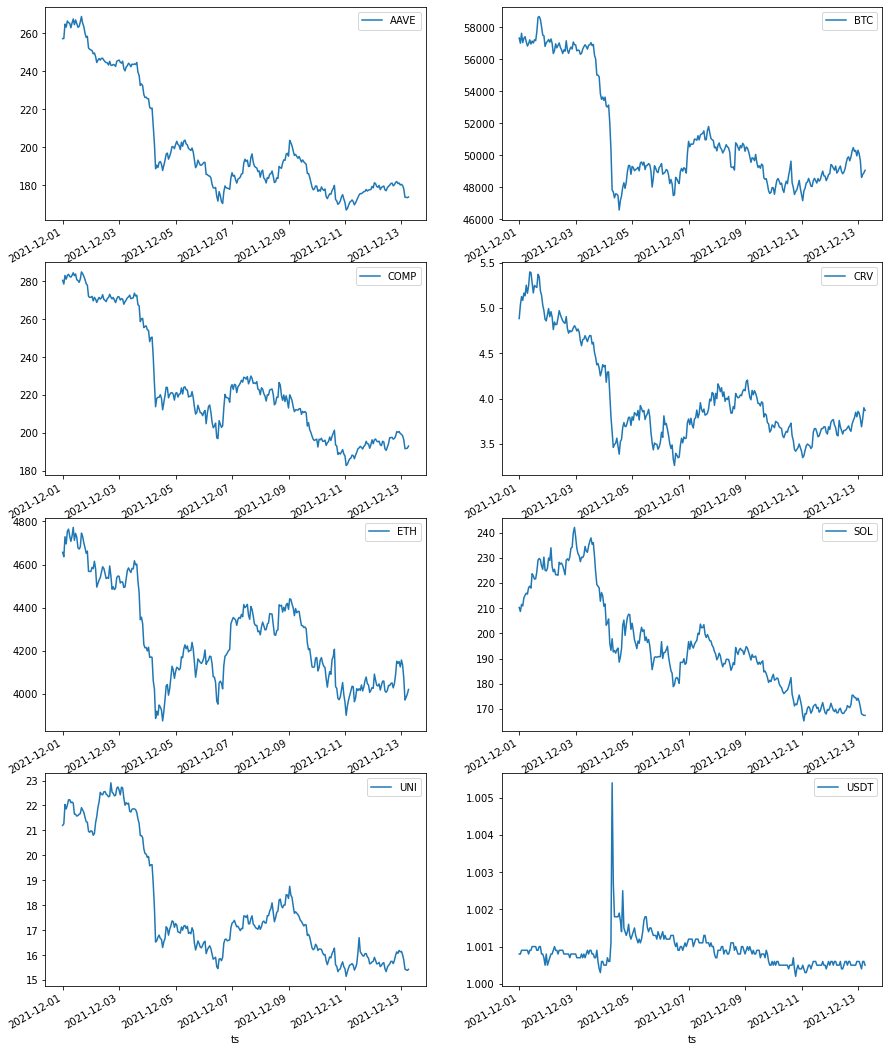

In [15]:
tokens_clean_df = clean_df.token.unique()

fig, axes = plt.subplots(nrows=math.ceil(tokens_clean_df.size / 2), ncols=2, figsize=(15, 5 * math.ceil(tokens_clean_df.size / 2)))

idx = 0
for label, df_token2 in clean_df[['token', 'open',"ts"]].groupby('token'):
    df_token2.set_index("ts")['open'].plot(ax=axes[idx // 2, idx % 2], label=label)
    axes[idx // 2, idx % 2].legend()
    
    
    idx += 1

In [16]:
clean_df['volumeUSD'] = clean_df['volume'] * clean_df['close']
volumeUSD_chain = clean_df.groupby('chain')['volumeUSD'].sum().sort_values(ascending=False).to_frame()
volumeUSD_chain

,volumeUSD
chain,
ETH,1.364857e+10
BTC,1.095975e+10
SOL,4.076323e+09
USDT,1.008252e+09
